In [1]:
from src import dataset_, model_, train_, inference_
from src.utils import *
import seaborn as sns
import umap
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

Load Data

In [2]:
total_df = pd.read_feather('/home/yeonmo/2023/study/2023_KCS/H2_Ar/data/h2_ar_df.ftr')
oes_list = pd.read_pickle('/home/yeonmo/2023/study/2023_KCS/H2_Ar/data/wavelengths_30.pkl')
dataset_dict = pd.read_pickle('/home/yeonmo/2023/study/2023_KCS/H2_Ar/data/dataset_dict_fix.pkl')

In [3]:
key_list = ['id', 'cycle']
info_list = ['time', 'torr', 'leak']

wafer_columns = info_list + key_list + oes_list
wafer_df = total_df.loc[:, wafer_columns]

total_wafer =  sort_wafer_by_time(wafer_df, key_list)

fin_wafer_df = pd.concat([w for i, w in total_wafer], axis = 0).reset_index(drop=True)
cycle_dict = get_cycle_dict(fin_wafer_df, wafer_columns, key_list, info_list)

pre_train_set, train_set, test_set = dataset_dict['pre_train'], dataset_dict['train'], dataset_dict['test']

In [4]:
fin_dataset_list = [pre_train_set, train_set, test_set]

for dataset in fin_dataset_list:
    print(pd.Series([wafer.leak.unique()[0] for info, wafer in dataset]).value_counts())

1.0    90
dtype: int64
 0.0    323
 1.0     59
-1.0      9
dtype: int64
0.0    108
1.0     72
dtype: int64


Make data loader

In [5]:
max_len = np.max([len(w) for i, w in total_wafer]) 

pre_train_dataset = dataset_.dataset_base_ae(pre_train_set, max_len, cycle_dict, oes_list)
train_dataset = dataset_.dataset_base_ae(train_set, max_len, cycle_dict, oes_list)
test_dataset = dataset_.dataset_base_ae(test_set, max_len, cycle_dict, oes_list)

pre_train_loader = DataLoader(pre_train_dataset, batch_size=30, drop_last=True)
train_loader = DataLoader(train_dataset, batch_size=32, drop_last=True, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=12, drop_last=False)

Load trained SS-LAD model

In [6]:
sensor_num = train_dataset[0][0].shape[0]
latent_dim = 100
VAE = model_.base_VAE(sensor_num, latent_dim).to(device)
ss_lad_model = VAE.encoder

best_model_path = '/home/yeonmo/2023/study/2023_KCS/H2_Ar/Model_jup/Deep_SAD_VAE_channel/2023_01_13'
model_pt = glob.glob(best_model_path + '/*')[-1]
print(model_pt)

checkpoint = torch.load(model_pt)
ss_lad_model.load_state_dict((checkpoint['model_state_dict']))

/home/yeonmo/2023/study/2023_KCS/H2_Ar/Model_jup/Deep_SAD_VAE_channel/2023_01_13/Deep_SAD_channel_epoch_388_valid_loss_0.4775435986618201.pt


<All keys matched successfully>

Get hypersphere center

In [12]:
ss_lad_center = inference_.get_hypersphere_center(ss_lad_model, pre_train_loader, device, type ='vae')

100%|██████████| 3/3 [00:00<00:00,  8.76it/s]


Inference SS-LAD

In [13]:
layer_range = [0,1,2,3,4]
fin_concat_latent, fin_label_list = inference_.inference_ss_lad(ss_lad_model, 
                                                                test_loader, 
                                                                device,
                                                                layer_range=layer_range,
                                                                type = 'vae')

Plot 2-dimension using UMAP

<AxesSubplot:xlabel='x_1', ylabel='x_2'>

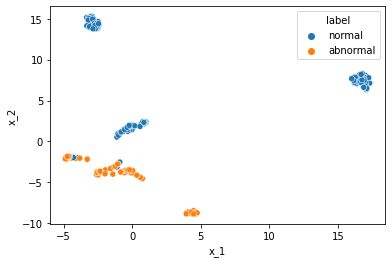

In [14]:
umap_ = umap.UMAP(n_components=2)
X_latent = umap_.fit_transform(fin_concat_latent)
latent_with_label = np.concatenate([X_latent, fin_label_list.reshape(-1, 1)], axis = 1)

fin_info_df = pd.DataFrame(latent_with_label, columns = ['x_1', 'x_2', 'label'])

fin_info_df.loc[fin_info_df[fin_info_df.label == 0].index, 'label'] = 'normal'
fin_info_df.loc[fin_info_df[fin_info_df.label == 1].index, 'label'] = 'abnormal'

sns.scatterplot(data = fin_info_df, x = 'x_1', y = 'x_2', hue = 'label')

Plot 2-dimension using TSNE

<AxesSubplot:xlabel='x_1', ylabel='x_2'>

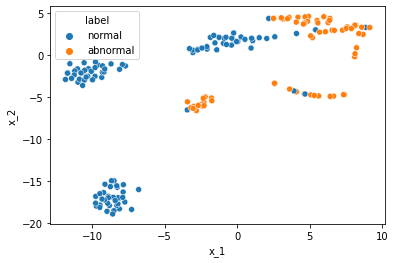

In [15]:
tsne_ = TSNE(n_components=2)
X_latent = tsne_.fit_transform(fin_concat_latent)
latent_with_label = np.concatenate([X_latent, fin_label_list.reshape(-1, 1)], axis = 1)

fin_info_df = pd.DataFrame(latent_with_label, columns = ['x_1', 'x_2', 'label'])

fin_info_df.loc[fin_info_df[fin_info_df.label == 0].index, 'label'] = 'normal'
fin_info_df.loc[fin_info_df[fin_info_df.label == 1].index, 'label'] = 'abnormal'

sns.scatterplot(data = fin_info_df, x = 'x_1', y = 'x_2', hue = 'label')

Load ss-vae only latent 

In [11]:
sensor_num = train_dataset[0][0].shape[0]
latent_dim = 100
VAE = model_.base_VAE(sensor_num, latent_dim).to(device)
ss_vae_model = VAE.encoder

best_model_path = '/home/yeonmo/2023/study/2023_KCS/H2_Ar/Model_jup/Deep_SAD_VAE_latent/2023_01_13'
model_pt = glob.glob(best_model_path + '/*')[-1]
print(model_pt)

checkpoint = torch.load(model_pt)
ss_vae_model.load_state_dict((checkpoint['model_state_dict']))

/home/yeonmo/2023/study/2023_KCS/H2_Ar/Model_jup/Deep_SAD_VAE_latent/2023_01_13/Deep_SAD_latent_epoch_360_valid_loss_0.0014671547348067786.pt


<All keys matched successfully>

Get ss-vae center|

In [16]:
ss_vae_center = inference_.get_hypersphere_center(ss_vae_model, pre_train_loader, device, type ='vae')

100%|██████████| 3/3 [00:00<00:00,  9.14it/s]


Inference SS-VAE

In [17]:
layer_range = [0,1,2,3,4]
fin_concat_latent, fin_label_list = inference_.inference_ss_lad(ss_vae_model, 
                                                                test_loader, 
                                                                device,
                                                                layer_range=layer_range,
                                                                type = 'ae')

Plot 2-dimension using UMAP

<AxesSubplot:xlabel='x_1', ylabel='x_2'>

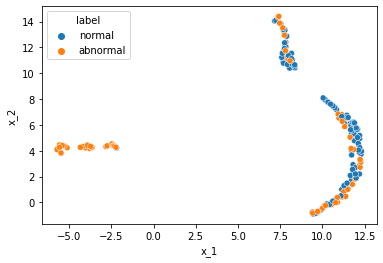

In [19]:
umap_ = umap.UMAP(n_components=2)
X_latent = umap_.fit_transform(fin_concat_latent)
latent_with_label = np.concatenate([X_latent, fin_label_list.reshape(-1, 1)], axis = 1)

fin_info_df = pd.DataFrame(latent_with_label, columns = ['x_1', 'x_2', 'label'])

fin_info_df.loc[fin_info_df[fin_info_df.label == 0].index, 'label'] = 'normal'
fin_info_df.loc[fin_info_df[fin_info_df.label == 1].index, 'label'] = 'abnormal'

sns.scatterplot(data = fin_info_df, x = 'x_1', y = 'x_2', hue = 'label')

Plot 2-dimension using TSNE

<AxesSubplot:xlabel='x_1', ylabel='x_2'>

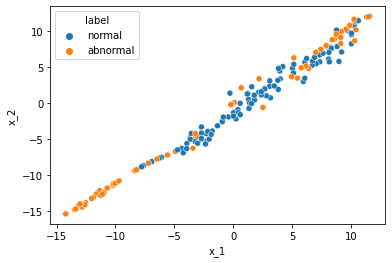

In [20]:
tsne_ = TSNE(n_components=2)
X_latent = tsne_.fit_transform(fin_concat_latent)
latent_with_label = np.concatenate([X_latent, fin_label_list.reshape(-1, 1)], axis = 1)

fin_info_df = pd.DataFrame(latent_with_label, columns = ['x_1', 'x_2', 'label'])

fin_info_df.loc[fin_info_df[fin_info_df.label == 0].index, 'label'] = 'normal'
fin_info_df.loc[fin_info_df[fin_info_df.label == 1].index, 'label'] = 'abnormal'

sns.scatterplot(data = fin_info_df, x = 'x_1', y = 'x_2', hue = 'label')